In [1]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pymc3 as pm
import arviz as az
import copy

WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
def binom_likelihood(theta,z,n):
    return (theta**z)*((1-theta)**(n-z))

In [3]:
def beta_param(ω,κ):
    return ω*(κ - 2) +1,(1 - ω)*(κ - 2) + 1 

In [4]:
def prior_calc(a,b,start,stop,step):
    theta = np.arange (start,stop,step)
    prior = sp.stats.beta.pdf(theta,a,b)
    plt.plot(theta,prior)
    return theta,prior

In [5]:
def data_calc(n,p):
    data=np.random.binomial(1,p,n)
    return data

In [6]:
def likelihood_calc(data,theta):

    n=len(data)
    z=np.count_nonzero(data == 1)
    pdata=0
    likelihood=[]
    for i in range(len(theta)):
        lkl=binom_likelihood(theta[i],z,n)
        likelihood.append(lkl)
        pdata+=prior[i]*lkl
    return likelihood,pdata

In [7]:
def posterior_calc(likelihood,prior,pdata,theta):
    posterior=[]
    for i in range(len(likelihood)):
        posterior.append(likelihood[i]*prior[i]/pdata)
    plt.plot(theta,posterior)   
    return posterior

### Analytical calculation

Non informative prior

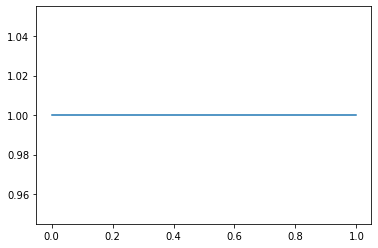

In [9]:
theta,prior=prior_calc(1,1, start=0, stop=1, step=0.001)

Data

In [10]:
sample_size=[1,2,3,4,1000,4000]
data_list=[]
for n in sample_size:
    data=data_calc(n,0.25)
    data_list.append(data)

Likelihood

In [11]:
likelihood_list=[]
pdata_list=[]
for data in data_list:
    likelihood,pdata=likelihood_calc(data,theta)
    likelihood_list.append(likelihood)
    pdata_list.append(pdata)

Posterior

<ipython-input-7-9a0afc42833d>:4: RuntimeWarning: invalid value encountered in double_scalars
  posterior.append(likelihood[i]*prior[i]/pdata)


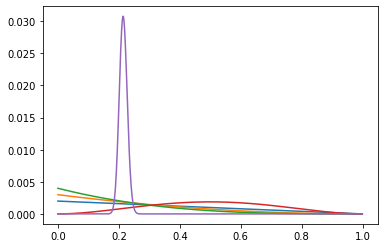

In [12]:
for i in range(len(likelihood_list)):
    posterior=posterior_calc(likelihood_list[i],prior,pdata_list[i],theta)

In [13]:
def display_posterior(prior,theta,data):
    
    n=len(data)
    if n>1:
        z=np.count_nonzero(data == 1)
    else:
        z=data[0]
    pdata=0
    likelihood=[]
    for i in range(len(theta)):
        lkl=binom_likelihood(theta[i],z,n)
        likelihood.append(lkl)
        pdata+=prior[i]*lkl
    posterior=[]
    for i in range(len(likelihood)):
        posterior.append(likelihood[i]*prior[i]/pdata)
    plt.plot(theta,posterior)  
    return posterior

One by one

In [14]:
data_list=[]
data=data_calc(4,0.25)
data_list.append(data)

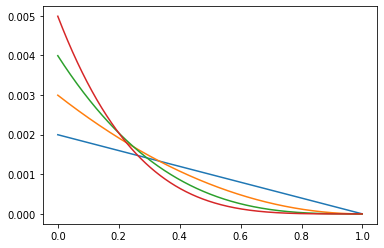

In [15]:
posterior1=display_posterior(prior,theta,[data_list[0][0]])
posterior2=display_posterior(posterior1,theta,[data_list[0][1]])
posterior3=display_posterior(posterior2,theta,[data_list[0][2]])
posterior4=display_posterior(posterior3,theta,[data_list[0][3]])

All at once

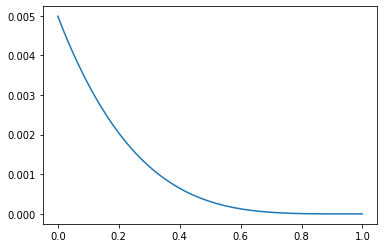

In [16]:
temp=display_posterior(prior,theta,data_list[0])

### Doing above calculations with MCMC

### Metropolis algorithm

In [17]:
def proposed_move(theta_curr):
    prop=np.random.normal(loc=0.0, scale=0.2, size=None)
    theta_prop=theta_curr+prop
    return round(theta_prop,2)

def P_theta_calc(th,data):
    
    n=len(data)
    z=np.count_nonzero(data == 1)
    likelihood=binom_likelihood(th,z,n)
    theta_idx=np.where(theta == th)
    P_theta=likelihood*prior[theta_idx]
    return P_theta

def decide_move(P_theta_prop,P_theta_curr,theta_prop,theta_curr):
    pmove=min((P_theta_prop/P_theta_curr),1)
    if pmove>np.random.uniform(low=0.0, high=1.0):
        theta_curr=theta_prop #accept_move
    return theta_curr

Observations= [array([0, 0, 0, 1])]


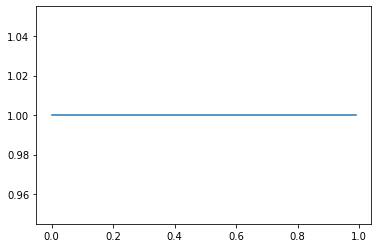

In [18]:
data=[]
d=data_calc(4,0.25)
data.append(d)
print('Observations=',data)
theta,prior=prior_calc(1,1,0,1,.01)

<ipython-input-195-d92496e9be21>:16: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  pmove=min((P_theta_prop/P_theta_curr),1)
<ipython-input-195-d92496e9be21>:17: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if pmove>np.random.uniform(low=0.0, high=1.0):


(array([1521.,  882.,  570.,  453.,  246.,  143.,  101.,   49.,   31.,
           4.]),
 array([0.   , 0.081, 0.162, 0.243, 0.324, 0.405, 0.486, 0.567, 0.648,
        0.729, 0.81 ]),
 <a list of 10 Patch objects>)

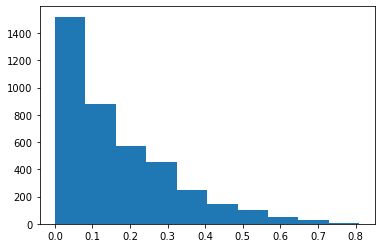

In [199]:
theta_curr=np.random.choice(theta, size=None, replace=True) #initialise random starting point
posterior=[]
for i in range(4000):
    theta_prop=proposed_move(theta_curr)
    P_theta_curr=P_theta_calc(theta_curr,data[0])
    P_theta_prop=P_theta_calc(theta_prop,data[0])
    theta_curr=decide_move(P_theta_prop,P_theta_curr,theta_prop,theta_curr)
    posterior.append(theta_curr)
plt.hist(posterior)

### PyMC3 

In [280]:
def generate_hdi(traces,parameter):
    lower,upper=az.hdi(traces[str(parameter)])
    plt.hist(traces[parameter], range=(lower,upper))

Priors

In [141]:
#priors:uniform(1,1),modes at 0.25, 0.5, 0.75
priors=[(1,1)]
modes=[0.25,0.5,0.75]
for w in modes:
    a,b=beta_param(w,5)
    priors.append((a,b))

Data

In [290]:
n=4
p=0.25
y=np.random.binomial(1, p, n)
print('Obeservations:',y)

Obeservations: [0 1 1 0]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 41 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.5,0.19,0.14,0.83,0.01,0.0,1445.87,1445.87,1482.71,2443.26,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 44 seconds.
The acceptance probability does not match the target. It is 0.8819788522886464, but should be close to 0.8. Try to increase the number of tuning steps.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.42,0.16,0.13,0.7,0.0,0.0,1475.42,1475.42,1494.83,2217.45,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 45 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.5,0.16,0.2,0.78,0.0,0.0,1793.54,1777.85,1827.82,2687.12,1.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 38 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.58,0.15,0.3,0.87,0.0,0.0,1485.67,1473.95,1502.64,2378.67,1.0


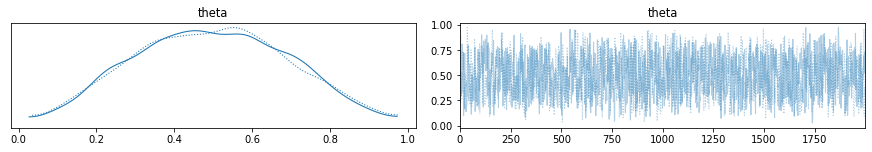

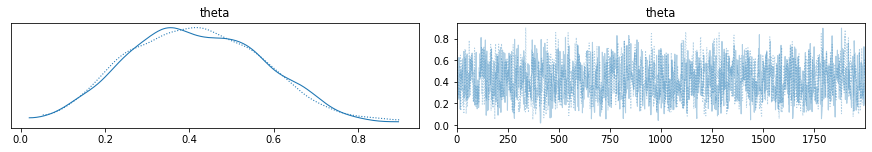

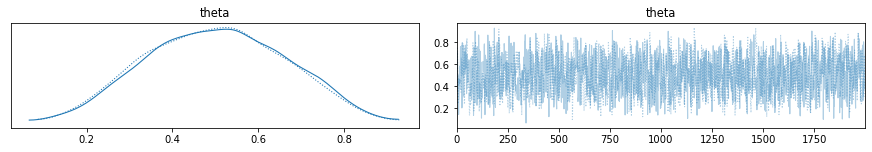

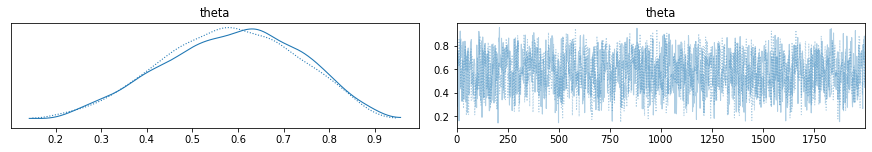

In [291]:
from pymc3 import Beta, Bernoulli

traces=[]
for prior in priors:
    basic_model = Model()
    with basic_model:
# Priors for unknown model parameters
        theta = Beta('theta', alpha=prior[0],beta=prior[1])
# Likelihood (sampling distribution) of observations
        yl = Bernoulli("yl",theta, observed=y)
        trace = pm.sample(2000, progressbar=False,return_inferencedata=False)
        traces.append(trace)
        az.plot_trace(trace);
        display(az.summary(trace, round_to=2))

Progression of distribution

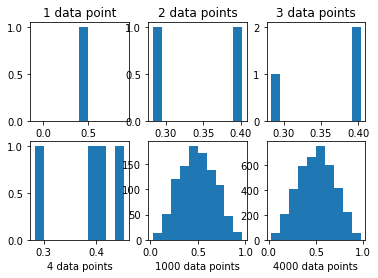

In [357]:
titles=["1 data point","2 data points","3 data points","4 data points","1000 data points","4000 data points"]
points=[1,2,3,4,1000,4000]

for i in range (6):
    plt.subplot(2, 3, i+1)
    plt.hist(trace['theta'][0:points[i]])
    if i<3: 
        plt.title(titles[i])
    else:
         plt.xlabel(titles[i])

plt.show()

### Entering data items one-by-one

First data item

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 32 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.34,0.24,0.0,0.75,0.01,0.0,1764.98,1764.98,1688.5,1651.23,1.0


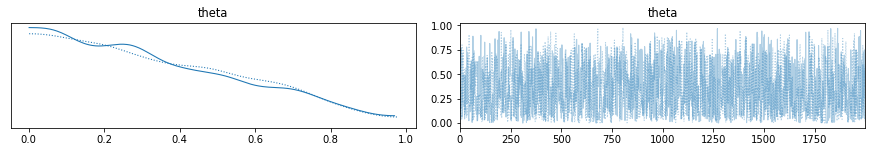

In [308]:
temp=copy.deepcopy(y) #copying data generated for previous analysis
y=temp[0]

traces_list3=[]
basic_model = Model()
with basic_model:
# Priors for unknown model parameters
    theta = Beta('theta', alpha=1,beta=1)
# Likelihood (sampling distribution) of observations
    yl = Bernoulli("yl",theta, observed=y)
    trace = pm.sample(2000, progressbar=False,return_inferencedata=False)
    traces_list3.append(trace)
    az.plot_trace(trace);
    display(az.summary(trace, round_to=2))

Second data item

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 33 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.51,0.22,0.13,0.93,0.01,0.0,1752.99,1752.99,1769.08,2335.24,1.0


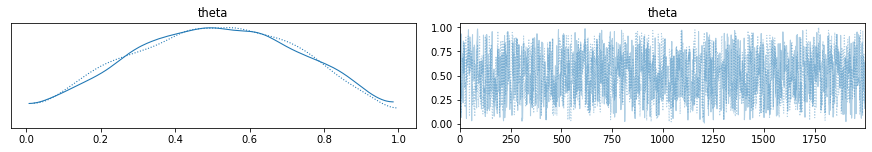

In [319]:
n=1
z=np.sum(temp[0])
y=temp[1]

basic_model = Model()
with basic_model:
# Priors for unknown model parameters
    theta = Beta('theta', alpha=1+z,beta=1+(n-z))
# Likelihood (sampling distribution) of observations
    yl = Bernoulli("yl",theta, observed=y)
    trace = pm.sample(2000, progressbar=False,return_inferencedata=False)
    traces_list3.append(trace)
    az.plot_trace(trace);
    display(az.summary(trace, round_to=2))

 Third data item

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 34 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.6,0.2,0.25,0.96,0.01,0.0,1473.51,1396.3,1421.55,1856.56,1.0


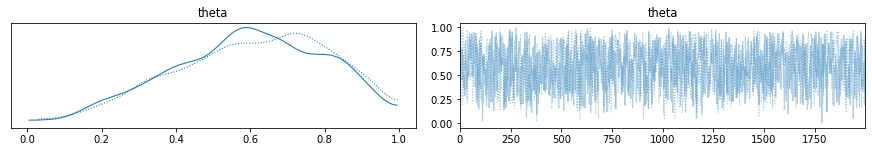

In [321]:
n=2
z=np.sum(temp[0:2])
y=temp[2]

basic_model = Model()
with basic_model:
# Priors for unknown model parameters
    theta = Beta('theta', alpha=1+z,beta=1+n-z)
# Likelihood (sampling distribution) of observations
    yl = Bernoulli("yl",theta, observed=y)
    trace = pm.sample(2000, progressbar=False,return_inferencedata=False)
    traces_list3.append(trace)
    az.plot_trace(trace);
    display(az.summary(trace, round_to=2))

Fourth data item

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 42 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.5,0.19,0.17,0.84,0.0,0.0,2012.95,1991.31,2068.32,2847.88,1.0


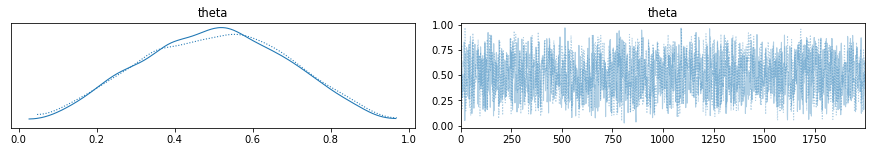

In [323]:
n=3
z=np.sum(temp[0:3])
y=temp[3]

basic_model = Model()
with basic_model:
# Priors for unknown model parameters
    theta = Beta('theta', alpha=1+z,beta=1+(n-z))
# Likelihood (sampling distribution) of observations
    yl = Bernoulli("yl",theta, observed=y)
    trace = pm.sample(2000, progressbar=False,return_inferencedata=False)
    traces_list3.append(trace)
    az.plot_trace(trace);
    display(az.summary(trace, round_to=2))

## Height weight correlation 

In [44]:
def data_generator(al,sd,bt,n):
    
# True parameter values
    alpha, sigma = al, sd
    beta = bt

# Size of dataset
    size = n
# height
    h = np.random.normal(1.7, 0.1, size)
# Simulate outcome variable
    Y = alpha + beta*h + np.random.randn(size)*sigma
    return h,Y

### Prior 1 - Non informative

In [261]:
alpha=0
sigma=3
beta=40
sample=[10,100,1000]

C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 94 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,6.70,5.93,0.00,18.48,2.19,1.62,7.31,7.31,7.74,51.14,1.19
beta,36.00,3.54,28.99,40.29,1.31,0.97,7.31,7.23,7.82,51.03,1.19
sigma,2.49,0.68,1.45,3.73,0.06,0.04,131.50,131.50,123.80,493.02,1.02


C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 323 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,5.34,2.97,0.04,9.73,0.84,0.61,12.50,12.50,13.21,41.91,1.08
beta,36.87,1.75,34.24,40.10,0.49,0.36,12.48,12.45,13.18,40.93,1.08
sigma,2.65,0.19,2.29,2.97,0.01,0.00,929.37,923.31,937.34,820.81,1.00


C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 3144 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.83,0.64,0.01,2.05,0.19,0.15,10.99,9.74,13.84,27.85,1.13
beta,39.62,0.38,38.87,40.13,0.11,0.08,11.10,11.10,14.18,28.29,1.12
sigma,3.04,0.07,2.92,3.18,0.00,0.00,910.32,905.28,904.47,645.97,1.00


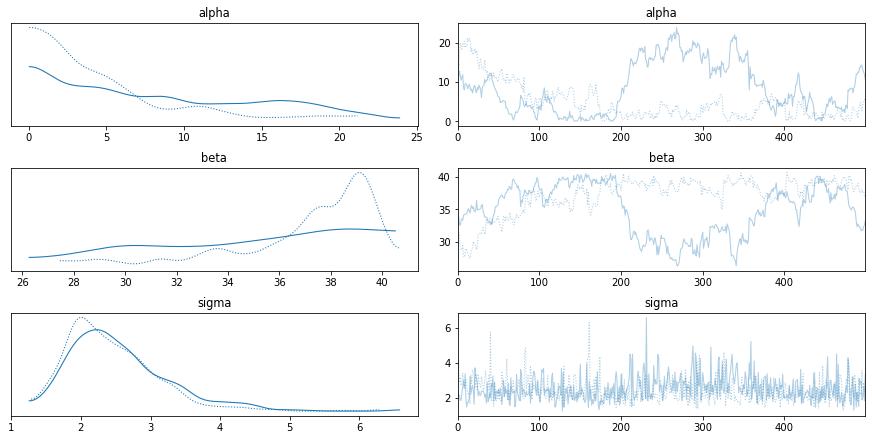

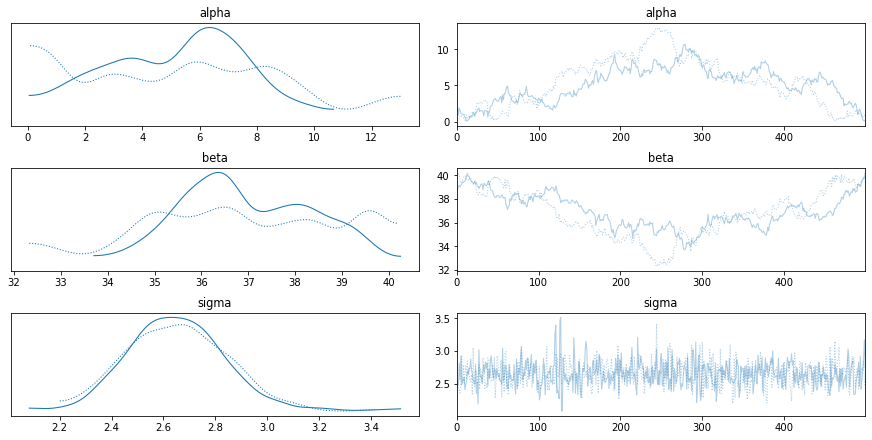

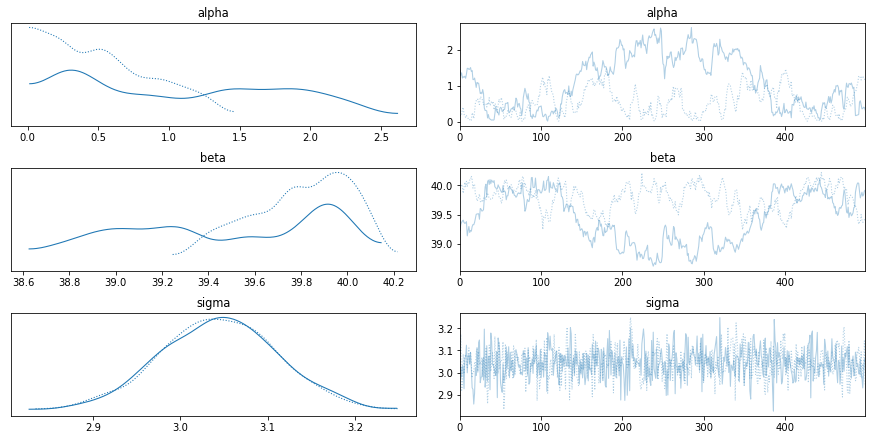

In [267]:
from pymc3 import Model, Normal,Uniform

traces_list=[]

for n in sample:
    h,Y=data_generator(0,3,40,n)
    basic_model = Model()
    with basic_model:
# Priors for unknown model parameters
        alpha = Uniform('alpha', lower=0, upper=100)
        beta = Uniform('beta', lower=0, upper=100)
        sigma = Uniform('sigma', lower=0, upper=100)
# Expected value of outcome
        mu = alpha + beta*h 
# Likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
# draw 500 posterior samples
        start = pm.find_MAP() # Find good starting point
        step = pm.Slice() # Instantiate MCMC sampling algorithm
        trace = pm.sample(500, step, start=start, return_inferencedata=False)
        traces_list.append(trace)
        az.plot_trace(trace)
        display(az.summary(trace, round_to=2))

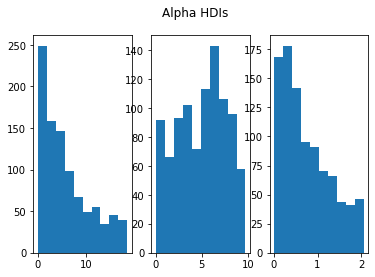

In [366]:
for i in range (3):
    plt.subplot(1, 3, i+1)
    lower,upper=az.hdi(traces_list[i]['alpha'])
    plt.hist(traces_list[i]['alpha'], range=(lower,upper))
    
plt.suptitle('Alpha HDIs')
plt.show()

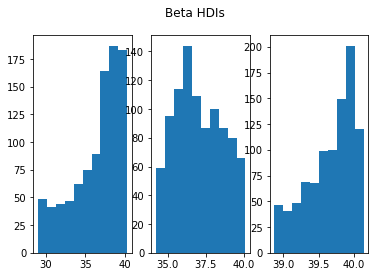

In [367]:
for i in range (3):
    plt.subplot(1, 3, i+1)
    lower,upper=az.hdi(traces_list[i]['beta'])
    plt.hist(traces_list[i]['beta'], range=(lower,upper))
    
plt.suptitle('Beta HDIs')
plt.show()

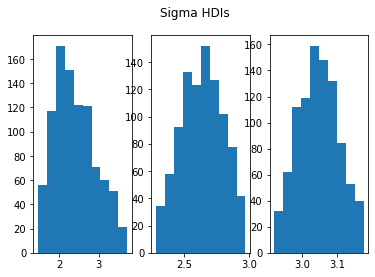

In [368]:
for i in range (3):
    plt.subplot(1, 3, i+1)
    lower,upper=az.hdi(traces_list[i]['sigma'])
    plt.hist(traces_list[i]['sigma'], range=(lower,upper))
    
plt.suptitle('Sigma HDIs')
plt.show()


In [270]:
#posterior to be used as prior in the next simulation
parameters=['alpha','beta','sigma']
post_list=[]
for p in parameters:
    post_list.append((round(traces_list[0][p].mean(),2),round(traces_list[0][p].std(),2)))

### Prior 2- Informative 

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 100 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,5.28,3.92,-2.12,12.29,0.46,0.33,71.80,71.80,73.45,109.18,1.06
beta,37.01,2.31,33.26,41.91,0.27,0.20,71.00,70.70,72.65,120.82,1.06
sigma,3.67,0.42,2.86,4.42,0.01,0.01,1012.77,993.51,1023.74,798.11,1.00


C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 422 seconds.
The rhat statistic is larger than 1.2 for some parameters.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,6.87,2.65,1.66,11.06,1.01,0.74,6.93,6.93,6.75,28.17,1.21
beta,36.10,1.55,33.58,39.15,0.59,0.44,6.92,6.82,6.76,26.21,1.21
sigma,2.95,0.19,2.64,3.33,0.01,0.00,927.37,912.11,951.95,623.60,1.01


C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\samru\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Slice: [sigma]
>Slice: [beta]
>Slice: [alpha]


Sampling 2 chains for 1_000 tune and 500 draw iterations (2_000 + 1_000 draws total) took 3624 seconds.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,-1.50,0.83,-2.56,0.53,0.46,0.36,3.27,3.27,3.83,13.25,1.5
beta,40.82,0.49,39.67,41.50,0.27,0.21,3.27,3.27,3.83,12.57,1.5
sigma,2.87,0.07,2.74,3.00,0.00,0.00,917.48,917.20,911.07,687.64,1.0


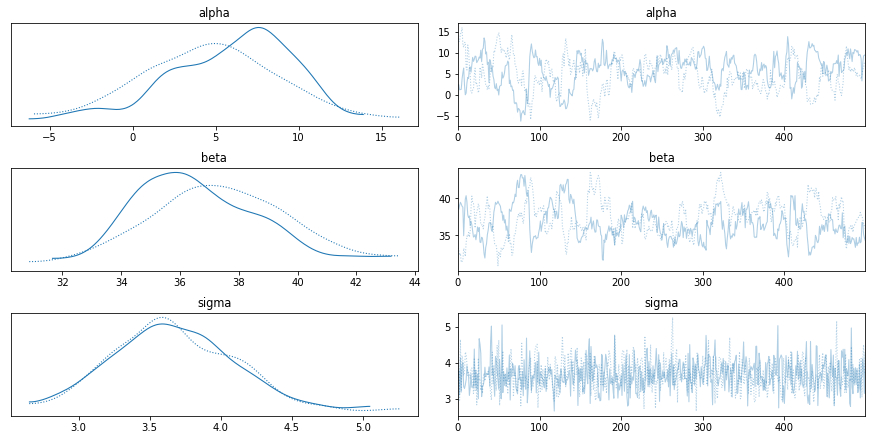

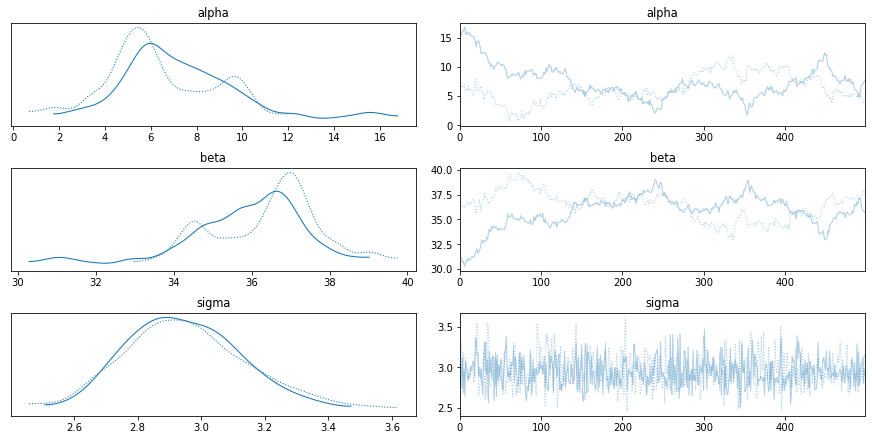

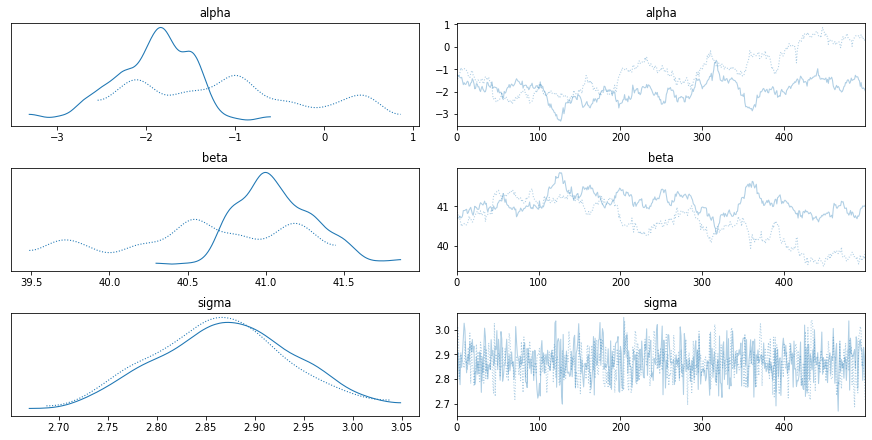

In [273]:
traces_list2=[]

for n in sample:
    h,Y=data_generator(0,3,40,n)
    basic_model = Model()
    with basic_model:
# Priors for unknown model parameters
        alpha = Normal('alpha',mu=post_list[0][0], sd=post_list[0][1])
        beta = Normal('beta', mu=post_list[1][0], sd=post_list[1][1])
        sigma = Normal('sigma',mu=post_list[2][0], sd=post_list[2][1])                                  
# Expected value of outcome
        mu = alpha + beta*h 
# Likelihood (sampling distribution) of observations
        Y_obs = Normal('Y_obs', mu=mu, sd=sigma, observed=Y)
# draw 500 posterior samples
        start = pm.find_MAP() # Find good starting point
        step = pm.Slice() # Instantiate MCMC sampling algorithm
        trace = pm.sample(500, step, start=start, return_inferencedata=False)
        traces_list2.append(trace)
        az.plot_trace(trace)
        display(az.summary(trace, round_to=2))

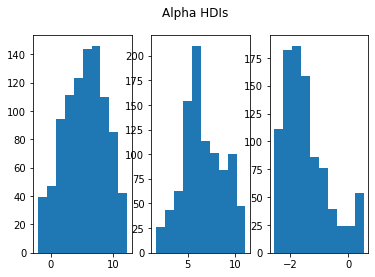

In [362]:
for i in range (3):
    plt.subplot(1, 3, i+1)
    lower,upper=az.hdi(traces_list2[i]['alpha'])
    plt.hist(traces_list2[i]['alpha'], range=(lower,upper))
    
plt.suptitle('Alpha HDIs')
plt.show()

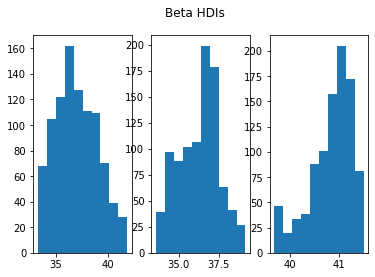

In [361]:
for i in range (3):
    plt.subplot(1, 3, i+1)
    lower,upper=az.hdi(traces_list2[i]['beta'])
    plt.hist(traces_list2[i]['beta'], range=(lower,upper))
    
plt.suptitle('Beta HDIs')
plt.show()

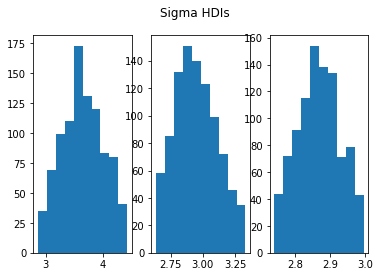

In [360]:
for i in range (3):
    plt.subplot(1, 3, i+1)
    lower,upper=az.hdi(traces_list2[i]['sigma'])
    plt.hist(traces_list2[i]['sigma'], range=(lower,upper))
    
plt.suptitle('Sigma HDIs')
plt.show()
